In [1]:
##Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timezone
import requests
from datetime import datetime
from urllib.parse import urlencode
import json
import time
from tabulate import tabulate


In [2]:
def determine_era(match_date):
    match_date = pd.to_datetime(match_date, utc=True)
    today = datetime.now(timezone.utc)

    if match_date > today:
        return "Not played yet"
    elif match_date < pd.to_datetime('2022-07-09', utc=True):
        return "Before Lorenzo"
    elif match_date > pd.to_datetime('2024-06-20', utc=True):
        return "Copa America"
    else:
        return "During Lorenzo"

def process_fixtures(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    matches = data.get('matches', [])

    fixture_data = []
    for match in matches:
        home_team = match['home']
        away_team = match['away']
        status = match['status']

        # Determine the winner
        if home_team['score'] > away_team['score']:
            winner = home_team['name']
        elif away_team['score'] > home_team['score']:
            winner = away_team['name']
        else:
            winner = "Draw"

        # Convert UTC time to datetime object with timezone information
        utc_time = datetime.strptime(status['utcTime'], '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=timezone.utc)

        fixture_data.append({
            'match_id': match['id'],
            'home_id': home_team['id'],
            'home_name': home_team['name'],
            'home_score': home_team['score'],
            'away_id': away_team['id'],
            'away_name': away_team['name'],
            'away_score': away_team['score'],
            'winner': winner,
            'tournament_name': match['tournament']['name'],
            'date': utc_time
        })

    df = pd.DataFrame(fixture_data)
    df['ERA'] = df['date'].apply(determine_era)
    return df

# URLs to process
urls = [
    "https://www.fotmob.com/api/pageableFixtures?teamId=8258&before=4196508",
    "https://www.fotmob.com/api/pageableFixtures?teamId=8258&before=4162527"
]

# Process both URLs and concatenate the results
all_fixtures = pd.concat([process_fixtures(url) for url in urls], ignore_index=True)

# Display the first few rows of the DataFrame
print(all_fixtures.head())

# all_fixtures.to_csv('colombia_fixtures.csv', index=False)
print("\nData saved to colombia_fixtures.csv")

# Print basic statistics
print("\nDataset Statistics:")
print(f"Total fixtures: {len(all_fixtures)}")
print(f"Date range: from {all_fixtures['date'].min()} to {all_fixtures['date'].max()}")
print("\nMost common tournaments:")
print(all_fixtures['tournament_name'].value_counts().head())
print("\nERA distribution:")
print(all_fixtures['ERA'].value_counts())

   match_id  home_id home_name  home_score  away_id  away_name  away_score  \
0   4162527     8258  Colombia           1     5819       Iraq           0   
1   4162528     8570   Germany           0     8258   Colombia           2   
2   4196504     8258  Colombia           1     5800  Venezuela           0   
3   4196497     9762     Chile           0     8258   Colombia           0   
4   4196495     8258  Colombia           2     5796    Uruguay           2   

     winner                   tournament_name                      date  \
0  Colombia                        Friendlies 2023-06-16 19:00:00+00:00   
1  Colombia                        Friendlies 2023-06-20 18:45:00+00:00   
2  Colombia  World Cup Qualification CONMEBOL 2023-09-07 23:00:00+00:00   
3      Draw  World Cup Qualification CONMEBOL 2023-09-13 00:30:00+00:00   
4      Draw  World Cup Qualification CONMEBOL 2023-10-12 20:30:00+00:00   

              ERA  
0  During Lorenzo  
1  During Lorenzo  
2  During Lorenzo  


In [3]:
def process_fixtures(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    matches = data.get('matches', [])

    fixture_data = []
    for match in matches:
        home_team = match['home']
        away_team = match['away']
        status = match['status']

        if home_team['score'] > away_team['score']:
            winner = home_team['name']
        elif away_team['score'] > home_team['score']:
            winner = away_team['name']
        else:
            winner = "Draw"

        utc_time = datetime.strptime(status['utcTime'], '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=timezone.utc)

        fixture_data.append({
            'match_id': match['id'],
            'home_id': home_team['id'],
            'home_name': home_team['name'],
            'home_score': home_team['score'],
            'away_id': away_team['id'],
            'away_name': away_team['name'],
            'away_score': away_team['score'],
            'winner': winner,
            'tournament_name': match['tournament']['name'],
            'date': utc_time
        })

    df = pd.DataFrame(fixture_data)
    df['ERA'] = df['date'].apply(determine_era)
    return df

def get_match_events(match_id, home_team, away_team):
    base_url = "https://www.fotmob.com/api/ltc"
    payload = {
        "ltcUrl": f"data.fotmob.com/webcl/ltc/gsm/{match_id}_en_gen.json.gz",
        "teams": json.dumps([home_team, away_team])
    }
    url = f"{base_url}?{urlencode(payload)}"

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for match {match_id}. Status code: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    events = data.get('events', [])

    event_data = []
    for event in events:
        executor_name, executor_team = get_player_info(event.get('players', []), 0)
        assistant_name, assistant_team = get_player_info(event.get('players', []), 1)
        time_data = event.get('time', {})
        time_main = time_data.get('main', '') if isinstance(time_data, dict) else ''
        time_added = time_data.get('added', '') if isinstance(time_data, dict) else ''

        event_data.append({
            'match_id': match_id,
            'eventId': event.get('eventId', ''),
            'teamEvent': event.get('teamEvent', ''),
            'type': event.get('type', ''),
            'text': event.get('text', ''),
            'time_main': time_main,
            'time_added': time_added,
            'executor_name': executor_name,
            'executor_team': executor_team,
            'assistant_name': assistant_name,
            'assistant_team': assistant_team,
            'title_key': event.get('title', {}).get('key', ''),
            'title_value': event.get('title', {}).get('value', '')
        })

    return pd.DataFrame(event_data)

def get_player_info(players, index):
  if index < len(players):
      return players[index].get('name', ''), players[index].get('teamName', '')
  return '', ''

In [4]:
# Process both URLs and concatenate the results
all_fixtures = pd.concat([process_fixtures(url) for url in urls], ignore_index=True)

# Display the first few rows of the DataFrame
print(all_fixtures.head())

# all_fixtures.to_csv('colombia_fixtures.csv', index=False)
print("\nData saved to colombia_fixtures.csv")

# Print basic statistics grouped by ERA
print("\nDataset Statistics by ERA:")
for era in all_fixtures['ERA'].unique():
    era_data = all_fixtures[all_fixtures['ERA'] == era]
    print(f"\n{era}:")
    print(f"Total fixtures: {len(era_data)}")
    print(f"Date range: from {era_data['date'].min()} to {era_data['date'].max()}")
    print("\nMost common tournaments:")
    print(era_data['tournament_name'].value_counts().head())

# Print overall ERA distribution
print("\nOverall ERA distribution:")
print(all_fixtures['ERA'].value_counts())

   match_id  home_id home_name  home_score  away_id  away_name  away_score  \
0   4162527     8258  Colombia           1     5819       Iraq           0   
1   4162528     8570   Germany           0     8258   Colombia           2   
2   4196504     8258  Colombia           1     5800  Venezuela           0   
3   4196497     9762     Chile           0     8258   Colombia           0   
4   4196495     8258  Colombia           2     5796    Uruguay           2   

     winner                   tournament_name                      date  \
0  Colombia                        Friendlies 2023-06-16 19:00:00+00:00   
1  Colombia                        Friendlies 2023-06-20 18:45:00+00:00   
2  Colombia  World Cup Qualification CONMEBOL 2023-09-07 23:00:00+00:00   
3      Draw  World Cup Qualification CONMEBOL 2023-09-13 00:30:00+00:00   
4      Draw  World Cup Qualification CONMEBOL 2023-10-12 20:30:00+00:00   

              ERA  
0  During Lorenzo  
1  During Lorenzo  
2  During Lorenzo  


In [5]:
# Create a mapping from match_id to ERA
match_id_to_era = dict(zip(all_fixtures['match_id'], all_fixtures['ERA']))

# Gather events for each match
all_events = []
for _, match in all_fixtures.iterrows():
    print(f"Processing match: {match['home_name']} vs {match['away_name']}")
    events = get_match_events(match['match_id'], match['home_name'], match['away_name'])

    # Add ERA to the events DataFrame
    events['ERA'] = match['ERA']

    all_events.append(events)
    time.sleep(1)  # Add a delay to avoid overwhelming the server

# Concatenate all events
all_events_df = pd.concat(all_events, ignore_index=True)

# Display the first few rows of the events DataFrame
print(all_events_df.head())

# Save the events DataFrame to a CSV file
all_events_df.to_csv('all_match_events.csv', index=False)
print("\nAll match events data saved to all_match_events.csv")

# Print basic statistics
print("\nDataset Statistics:")
print(f"Total events: {len(all_events_df)}")
print("\nMost common event types:")
print(all_events_df['type'].value_counts().head())

# Print event statistics by ERA
print("\nEvent Statistics by ERA:")
for era in all_events_df['ERA'].unique():
    era_events = all_events_df[all_events_df['ERA'] == era]
    print(f"\n{era}:")
    print(f"Total events: {len(era_events)}")
    print("\nMost common event types:")
    print(era_events['type'].value_counts().head())

Processing match: Colombia vs Iraq
Processing match: Germany vs Colombia
Processing match: Colombia vs Venezuela
Processing match: Chile vs Colombia
Processing match: Colombia vs Uruguay
Processing match: Ecuador vs Colombia
Processing match: Colombia vs Brazil
Processing match: Paraguay vs Colombia
Processing match: Colombia vs Venezuela
Processing match: Mexico vs Colombia
Processing match: Spain vs Colombia
Processing match: Romania vs Colombia
Processing match: USA vs Colombia
Processing match: Colombia vs Bolivia
Processing match: Colombia vs Paraguay
Processing match: Colombia vs Costa Rica
Processing match: Brazil vs Colombia
Processing match: Colombia vs Panama
Processing match: Uruguay vs Colombia
Processing match: Peru vs Colombia
Processing match: Bolivia vs Colombia
Processing match: Paraguay vs Colombia
Processing match: Colombia vs Chile
Processing match: Uruguay vs Colombia
Processing match: Colombia vs Brazil
Processing match: Colombia vs Ecuador
Processing match: Brazi

In [6]:
print(all_events_df['type'].value_counts())

type
free kick lost                   824
free kick won                    786
SI                               299
miss                             248
corner                           228
attempt blocked                  154
attempt saved                    140
offside                          104
YC                               103
start delay                       66
end delay                         64
start                             60
G                                 59
lineup                            33
end 14                            30
end 1                             30
end 2                             30
post                              15
contentious referee decisions     12
penalty lost                      11
PSG                               10
penalty won                        9
Y2C                                3
VAR cancelled goal                 2
RC                                 2
PS                                 1
OG                               

In [7]:
# Filter for Colombia's events
colombia_events_df = all_events_df[all_events_df['executor_team'] == 'Colombia']

# Filter for header events by Colombia
header_pattern = r'\bheader\b|\bHeader\b'
colombia_header_events_df = colombia_events_df[colombia_events_df['text'].str.contains(header_pattern, case=False, na=False, regex=True)]

# Display the first few rows of the filtered DataFrame
print(colombia_header_events_df.head())

# colombia_header_events_df.to_csv('colombia_header_events.csv', index=False)
print("\nColombia's header events data saved to colombia_header_events.csv")

# Filter for Copa America era
copa_america_headers = colombia_header_events_df[colombia_header_events_df['ERA'] == 'Copa America']

# Count headers by player in Copa America
copa_america_player_headers = copa_america_headers['executor_name'].value_counts()

print("\nTop Header Players in Copa America:")
print(copa_america_player_headers.head(10))  # Show top 10 players

# Calculate percentage of headers for each player
total_copa_headers = copa_america_player_headers.sum()
copa_america_player_header_percentages = (copa_america_player_headers / total_copa_headers * 100).round(2)

print("\nPercentage of Headers by Player in Copa America:")
print(copa_america_player_header_percentages.head(10))  # Show top 10 players

# Save Copa America header statistics to CSV
copa_america_header_stats = pd.DataFrame({
    'Player': copa_america_player_headers.index,
    'Header Count': copa_america_player_headers.values,
    'Percentage': copa_america_player_header_percentages.values
})
copa_america_header_stats.to_csv('copa_america_header_stats.csv', index=False)
print("\nCopa America header statistics saved to copa_america_header_stats.csv")

# Calculate overall statistics
total_games = all_fixtures['match_id'].nunique()
total_colombia_header_events = len(colombia_header_events_df)
colombia_headers_per_game = total_colombia_header_events / total_games

print("\nOverall Colombia Header Events Statistics:")
print(f"Total games: {total_games}")
print(f"Total Colombia header events: {total_colombia_header_events}")
print(f"Colombia headers per game: {colombia_headers_per_game:.2f}")

print("\nMost common event types for Colombia's header events:")
print(colombia_header_events_df['type'].value_counts())

# Calculate statistics by ERA
era_stats = []
for era in colombia_header_events_df['ERA'].unique():
    era_fixtures = all_fixtures[all_fixtures['ERA'] == era]
    era_colombia_header_events = colombia_header_events_df[colombia_header_events_df['ERA'] == era]
    
    games_in_era = era_fixtures['match_id'].nunique()
    headers_in_era = len(era_colombia_header_events)
    headers_per_game_in_era = headers_in_era / games_in_era if games_in_era > 0 else 0
    
    most_common_type = era_colombia_header_events['type'].value_counts().index[0] if not era_colombia_header_events.empty else 'N/A'
    top_header_player = era_colombia_header_events['executor_name'].value_counts().index[0] if not era_colombia_header_events.empty else 'N/A'
    
    era_stats.append({
        'ERA': era,
        'Games': games_in_era,
        'Total Colombia Headers': headers_in_era,
        'Colombia Headers per Game': headers_per_game_in_era,
        'Most Common Type': most_common_type,
        'Top Header Player': top_header_player
    })

era_stats_df = pd.DataFrame(era_stats)
era_stats_df = era_stats_df.sort_values('Games', ascending=False)

print("\nColombia Header Events Statistics by ERA:")
print(era_stats_df.to_string(index=False))

# Calculate the percentage of Colombia's events that are headers in each ERA
total_colombia_events_by_era = colombia_events_df['ERA'].value_counts()
colombia_header_events_by_era = colombia_header_events_df['ERA'].value_counts()
percentage_headers_by_era = (colombia_header_events_by_era / total_colombia_events_by_era * 100).round(2)

print("\nPercentage of Colombia's events that are headers in each ERA:")
print(percentage_headers_by_era)

# Additional analysis: Headers by player across all eras
player_headers_all_eras = colombia_header_events_df['executor_name'].value_counts()
player_header_percentages_all_eras = (player_headers_all_eras / len(colombia_header_events_df) * 100).round(2)

print("\nTop Header Players Across All Eras:")
print(player_headers_all_eras.head(10))

print("\nPercentage of Headers by Player Across All Eras:")
print(player_header_percentages_all_eras.head(10))

# Save overall header statistics to CSV
overall_header_stats = pd.DataFrame({
    'Player': player_headers_all_eras.index,
    'Header Count': player_headers_all_eras.values,
    'Percentage': player_header_percentages_all_eras.values
})
overall_header_stats.to_csv('overall_header_stats.csv', index=False)
print("\nOverall header statistics saved to overall_header_stats.csv")

# Headers by player for each ERA
for era in colombia_header_events_df['ERA'].unique():
    era_headers = colombia_header_events_df[colombia_header_events_df['ERA'] == era]
    era_player_headers = era_headers['executor_name'].value_counts()
    era_player_header_percentages = (era_player_headers / len(era_headers) * 100).round(2)
    
    print(f"\nTop Header Players in {era} Era:")
    print(era_player_headers.head(10))
    
    print(f"\nPercentage of Headers by Player in {era} Era:")
    print(era_player_header_percentages.head(10))
    
    # # Save ERA-specific header statistics to CSV
    # era_header_stats = pd.DataFrame({
    #     'Player': era_player_headers.index,
    #     'Header Count': era_player_headers.values,
    #     'Percentage': era_player_header_percentages.values
    # })
    # # era_header_stats.to_csv(f'{era.lower().replace(" ", "_")}_header_stats.csv', index=False)
    # print(f"\n{era} header statistics saved to {era.lower().replace(' ', '_')}_header_stats.csv")

      match_id eventId teamEvent  type  \
33   4162527.0              home  miss   
58   4162527.0              home  miss   
99   4196504.0              home  miss   
112  4196504.0              home  miss   
114  4196504.0              home  miss   

                                                  text time_main time_added  \
33   Attempt missed. Jhon Lucumí (Colombia) header ...       58’       None   
58   Attempt missed. Davinson Sánchez (Colombia) he...       35’       None   
99   Attempt missed. Jhon Durán (Colombia) header f...       90’         +1   
112  Attempt missed. Jefferson Lerma (Colombia) hea...       81’       None   
114  Attempt missed. Luis Díaz (Colombia) header fr...       79’       None   

        executor_name executor_team   assistant_name assistant_team title_key  \
33        Jhon Lucumi      Colombia    Juan Cuadrado       Colombia             
58   Davinson Sánchez      Colombia  Jorge Carrascal       Colombia             
99         Jhon Duran      Co

In [8]:
# Filter for headers assisted by James Rodriguez
james_headers_df = colombia_header_events_df[
    (colombia_header_events_df['assistant_name'].str.contains('James Rodriguez', case=False, na=False)) |
    (colombia_header_events_df['assistant_name'].str.contains('James Rodríguez', case=False, na=False))  # Including accented version
]

# Print the count
print(f"\nTotal headers assisted by James Rodriguez: {len(james_headers_df)}")

# james_headers_df.to_csv('james_rodriguez_assisted_headers.csv', index=False)


Total headers assisted by James Rodriguez: 28


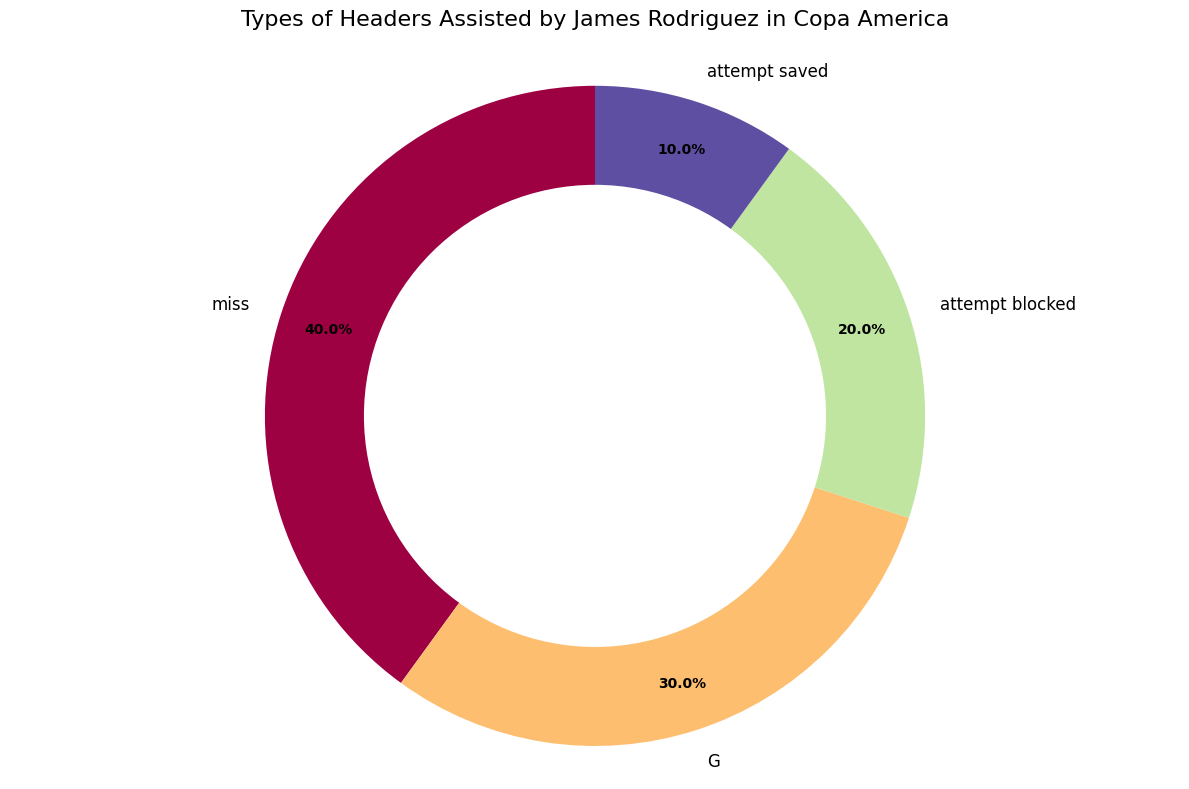

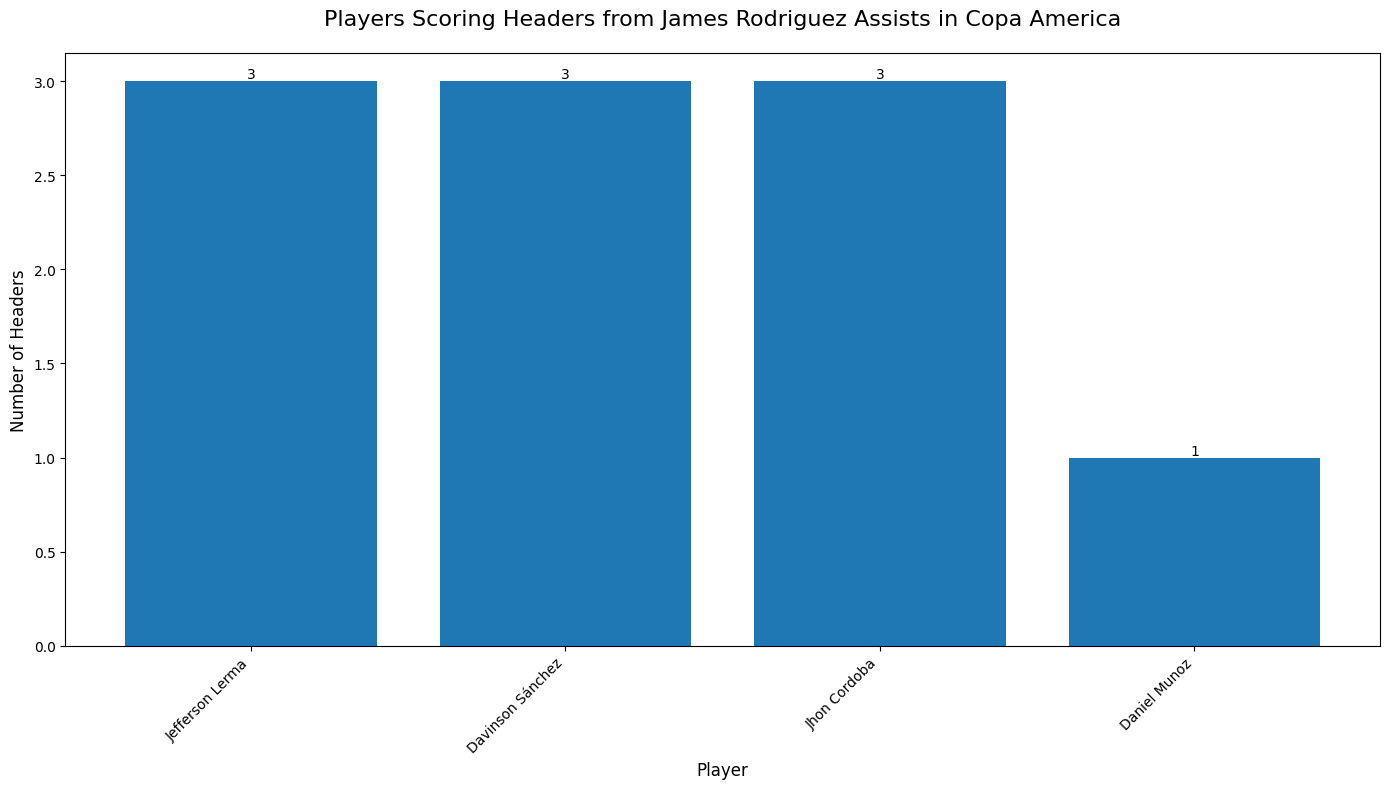

In [13]:
# Filter for Copa America era
copa_america_headers = james_headers_df[james_headers_df['ERA'] == 'Copa America']

if copa_america_headers.empty:
    print("No data available for Copa America era.")
else:
    # 1. Pie chart of header types in Copa America
    header_types = copa_america_headers['type'].value_counts()

    if header_types.empty:
        print("No header types data available for Copa America era.")
    else:
        plt.figure(figsize=(12, 8))
        colors = plt.cm.Spectral(np.linspace(0, 1, len(header_types)))
        wedges, texts, autotexts = plt.pie(header_types.values, labels=header_types.index, autopct='%1.1f%%', 
                                           colors=colors, startangle=90, pctdistance=0.85)
        plt.title('Types of Headers Assisted by James Rodriguez in Copa America', fontsize=16, pad=20)
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=12)
        # Add a circle at the center to make it a donut chart
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    # 2. Bar chart of players who scored from James' assists in Copa America
    scorers = copa_america_headers['executor_name'].value_counts()

    if scorers.empty:
        print("No scorer data available for Copa America era.")
    else:
        plt.figure(figsize=(14, 8))
        bars = plt.bar(scorers.index, scorers.values)
        plt.title('Players Scoring Headers from James Rodriguez Assists in Copa America', fontsize=16, pad=20)
        plt.xlabel('Player', fontsize=12)
        plt.ylabel('Number of Headers', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height}',
                     ha='center', va='bottom', fontsize=10)
        # Adjust layout to prevent cut-off labels
        plt.tight_layout()
        plt.show()

In [14]:
# Filter for freekick events from Colombia
freekick_pattern = r'\bfree[ -]?kick\b|\bfk\b'
colombia_freekicks_df = all_events_df[
    (all_events_df['text'].str.contains(freekick_pattern, case=False, na=False, regex=True)) &
    ((all_events_df['executor_team'] == 'Colombia') | (all_events_df['assistant_team'] == 'Colombia'))
]

# Display the results
print("Freekick events from Colombia:")
print(colombia_freekicks_df[['match_id', 'executor_name', 'executor_team', 'assistant_name', 'assistant_team', 'text', 'time_main', 'time_added']])

# Print the count
print(f"\nTotal freekick events from Colombia: {len(colombia_freekicks_df)}")

# colombia_freekicks_df.to_csv('colombia_freekick_events.csv', index=False)
# print("\nColombia freekick events saved to colombia_freekick_events.csv")

# Optional: Display some statistics
print("\nTop executors of freekicks for Colombia:")
print(colombia_freekicks_df['executor_name'].value_counts().head())

print("\nTypes of freekick events:")
print(colombia_freekicks_df['type'].value_counts())

Freekick events from Colombia:
       match_id    executor_name executor_team assistant_name assistant_team  \
5     4162527.0       Jhon Arias      Colombia                                 
21    4162527.0        Luis Diaz      Colombia                                 
45    4162527.0    Diego Valoyes      Colombia                                 
47    4162527.0  Jorge Carrascal      Colombia                                 
49    4162527.0        Luis Diaz      Colombia                                 
...         ...              ...           ...            ...            ...   
3298  4118862.0  Jorge Carrascal      Colombia                                 
3300  4118862.0  Jorge Carrascal      Colombia                                 
3303  4118862.0  Jorge Carrascal      Colombia                                 
3314  4118862.0       Jhon Arias      Colombia                                 
3319  4118862.0    Kevin Castano      Colombia                                 

        


ERA statistics saved to colombia_header_stats_by_era.csv

Overall Statistics for Colombia's Headers:
Total matches: 40
Total Colombia headers: 78
Total James Rodriguez assisted headers: 28
Total Colombia header goals: 11
Colombia headers per match: 1.95
James assisted headers per match: 0.70
Colombia header goals per match: 0.28
James assist percentage: 35.90%
Colombia header goal percentage: 14.10%
Filtered table image saved as 'colombia_headers_table_filtered.png'


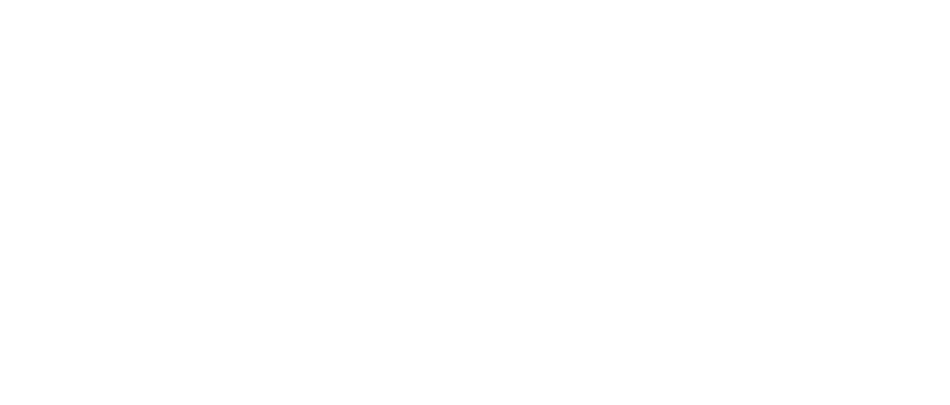

In [16]:
from textwrap import wrap

# Filter for Colombia's events first
colombia_events_df = all_events_df[all_events_df['executor_team'] == 'Colombia']

# Then filter for header events by Colombia
header_pattern = r'\bheader\b|\bHeader\b'
colombia_header_events_df = colombia_events_df[colombia_events_df['text'].str.contains(header_pattern, case=False, na=False, regex=True)]

# Create a DataFrame with header counts per match
header_counts = colombia_header_events_df.groupby('match_id').size().reset_index(name='total_headers')

# Count headers assisted by James Rodriguez
james_assisted_headers = colombia_header_events_df[
    colombia_header_events_df['assistant_name'].str.contains('James Rodr[ií]guez', case=False, na=False, regex=True)
].groupby('match_id').size().reset_index(name='james_assisted_headers')

# Count headers that resulted in goals
header_goals = colombia_header_events_df[
    colombia_header_events_df['type'].str.contains('G', case=False, na=False)
].groupby('match_id').size().reset_index(name='header_goals')

# Merge these counts with the Colombia fixtures
merged_df = all_fixtures.merge(header_counts, on='match_id', how='left')
merged_df = merged_df.merge(james_assisted_headers, on='match_id', how='left')
merged_df = merged_df.merge(header_goals, on='match_id', how='left')

# Fill NaN values with 0 for matches without any headers
merged_df['total_headers'] = merged_df['total_headers'].fillna(0)
merged_df['james_assisted_headers'] = merged_df['james_assisted_headers'].fillna(0)
merged_df['header_goals'] = merged_df['header_goals'].fillna(0)

# Convert to integers
merged_df['total_headers'] = merged_df['total_headers'].astype(int)
merged_df['james_assisted_headers'] = merged_df['james_assisted_headers'].astype(int)
merged_df['header_goals'] = merged_df['header_goals'].astype(int)

# Group by ERA and calculate statistics
era_stats = merged_df.groupby('ERA').agg({
    'match_id': 'count',
    'total_headers': 'sum',
    'james_assisted_headers': 'sum',
    'header_goals': 'sum'
}).reset_index()

era_stats = era_stats.rename(columns={
    'match_id': 'total_matches',
    'total_headers': 'total_headers',
    'james_assisted_headers': 'james_assisted_headers',
    'header_goals': 'header_goals'
})

era_stats['headers_per_match'] = era_stats['total_headers'] / era_stats['total_matches']
era_stats['james_headers_per_match'] = era_stats['james_assisted_headers'] / era_stats['total_matches']
era_stats['header_goals_per_match'] = era_stats['header_goals'] / era_stats['total_matches']

# Calculate percentages
era_stats['james_assist_percentage'] = (era_stats['james_assisted_headers'] / era_stats['total_headers'] * 100).round(2)
era_stats['header_goal_percentage'] = (era_stats['header_goals'] / era_stats['total_headers'] * 100).round(2)

# Sort by total_matches in descending order
era_stats = era_stats.sort_values('total_matches', ascending=False)

# Round floating-point numbers to 2 decimal places
for column in era_stats.select_dtypes(include=['float64']).columns:
    era_stats[column] = era_stats[column].round(2)

# Round floating-point numbers to 2 decimal places
for column in era_stats.select_dtypes(include=['float64']).columns:
    era_stats[column] = era_stats[column].round(2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, len(era_stats) + 1))

# Hide axes
ax.axis('tight')
ax.axis('off')

# Save the ERA statistics to a CSV file
era_stats.to_csv('colombia_header_stats_by_era.csv', index=False)
print("\nERA statistics saved to colombia_header_stats_by_era.csv")

# Overall statistics
print("\nOverall Statistics for Colombia's Headers:")
print(f"Total matches: {merged_df['match_id'].nunique()}")
print(f"Total Colombia headers: {merged_df['total_headers'].sum()}")
print(f"Total James Rodriguez assisted headers: {merged_df['james_assisted_headers'].sum()}")
print(f"Total Colombia header goals: {merged_df['header_goals'].sum()}")
print(f"Colombia headers per match: {merged_df['total_headers'].sum() / merged_df['match_id'].nunique():.2f}")
print(f"James assisted headers per match: {merged_df['james_assisted_headers'].sum() / merged_df['match_id'].nunique():.2f}")
print(f"Colombia header goals per match: {merged_df['header_goals'].sum() / merged_df['match_id'].nunique():.2f}")
print(f"James assist percentage: {merged_df['james_assisted_headers'].sum() / merged_df['total_headers'].sum() * 100:.2f}%")
print(f"Colombia header goal percentage: {merged_df['header_goals'].sum() / merged_df['total_headers'].sum() * 100:.2f}%")


# First, let's drop the James Rodriguez statistics and 'Not played yet' ERA
columns_to_keep = ['ERA', 'total_matches', 'total_headers', 'header_goals', 
                   'headers_per_match', 'header_goals_per_match', 'header_goal_percentage']
era_stats_filtered = era_stats[columns_to_keep]
era_stats_filtered = era_stats_filtered[era_stats_filtered['ERA'] != 'Not played yet']

# Round floating-point numbers to 2 decimal places
for column in era_stats_filtered.select_dtypes(include=['float64']).columns:
    era_stats_filtered[column] = era_stats_filtered[column].round(2)

# Create a mapping for shorter column names
column_name_map = {
    'total_matches': 'Matches',
    'total_headers': 'Headers',
    'header_goals': 'Goals',
    'headers_per_match': 'Headers/Match',
    'header_goals_per_match': 'Goals/Match',
    'header_goal_percentage': 'Goal %'
}

# Apply the mapping to get shorter column names
era_stats_filtered.columns = [column_name_map.get(col, col) for col in era_stats_filtered.columns]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, len(era_stats_filtered) + 1))

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=era_stats_filtered.values, colLabels=era_stats_filtered.columns, 
                 cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Color header and alternate rows, and wrap long headers
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4472C4')
        cell.set_text_props(wrap=True)
        cell.set_height(0.1)  # Increase height for wrapped text
        cell._text.set_text('\n'.join(wrap(cell._text.get_text(), 13)))  # Wrap text
    else:
        cell.set_facecolor('#E7F1FE' if row % 2 == 0 else 'white')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('colombia_headers_table_filtered.png', bbox_inches='tight', dpi=300)
plt.close()

print("Filtered table image saved as 'colombia_headers_table_filtered.png'")

In [17]:
def determine_era(match_date):
    match_date = pd.to_datetime(match_date)
    if match_date < pd.to_datetime('2022-07-09'):
        return "Before Lorenzo"
    elif match_date > pd.to_datetime('2024-06-20'):
        return "Copa America"
    else:
        return "During Lorenzo"

def get_player_stats(match_id):
    url = f"https://www.fotmob.com/api/matchDetails?matchId={match_id}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve data for match {match_id}. Status code: {response.status_code}")
        return pd.DataFrame()

    response_data = response.json()

    if 'content' not in response_data or 'lineup' not in response_data['content']:
        print(f"No lineup data available for match {match_id}")
        return pd.DataFrame()

    lineup_data = response_data['content']['lineup']
    if not isinstance(lineup_data, dict) or 'lineup' not in lineup_data:
        print(f"Unexpected lineup data structure for match {match_id}")
        return pd.DataFrame()

    players_data = lineup_data['lineup']

    if not players_data:
        print(f"No player data available for match {match_id}")
        return pd.DataFrame()

    def flatten_stats(stats):
        flattened = {}
        for stat_group in stats:
            group_key = stat_group['key']
            for key, value in stat_group['stats'].items():
                if isinstance(value, dict):
                    if 'value' in value:
                        flattened[f"{group_key}_{key}"] = value['value']
                    elif 'stat' in value and 'value' in value['stat']:
                        if 'total' in value['stat']:
                            flattened[f"{group_key}_{key}_value"] = value['stat']['value']
                            flattened[f"{group_key}_{key}_total"] = value['stat']['total']
                        else:
                            flattened[f"{group_key}_{key}"] = value['stat']['value']
                else:
                    flattened[f"{group_key}_{key}"] = value
        return flattened

    all_players_data = []

    try:
        home_team = players_data[0]['teamId']
        away_team = players_data[1]['teamId']
        match_info = response_data['general']['matchName']
        match_date_str = response_data['general']['matchTimeUTC']
        match_date = datetime.strptime(match_date_str, '%a, %b %d, %Y, %H:%M UTC')
    except (IndexError, KeyError, ValueError) as e:
        print(f"Error extracting team, match info, or date for match {match_id}: {e}")
        return pd.DataFrame()

    # Determine ERA using the new function
    era = determine_era(match_date)

    for team in players_data:
        team_id = team.get('teamId')
        if team_id is None:
            continue
        for player_list in team.get('players', []):
            if not isinstance(player_list, list):
                player_list = [player_list]
            for player in player_list:
                if team_id == 8258:  # Colombia team ID
                    player_data = {
                        'id': player.get('id'),
                        'name': player.get('name', {}).get('fullName'),
                        'team': team_id,
                        'position': player.get('position'),
                        'rating': player.get('rating', {}).get('num'),
                        'match': match_info,
                        'match_id': match_id,
                        'match_date': match_date.strftime('%Y-%m-%d'),
                        'home_away': 'home' if team_id == home_team else 'away',
                        'ERA': era
                    }

                    if 'stats' in player:
                        player_data.update(flatten_stats(player['stats']))

                    all_players_data.append(player_data)

    return pd.DataFrame(all_players_data)

# Assuming you have all_fixtures DataFrame
# If not, you need to load it first
# all_fixtures = pd.read_csv('colombia_fixtures.csv')

all_player_stats = []

for index, row in all_fixtures.iterrows():
    match_id = row['match_id']
    print(f"Processing match {match_id}")
    try:
        match_stats = get_player_stats(match_id)
        if not match_stats.empty:
            all_player_stats.append(match_stats)
    except Exception as e:
        print(f"Error processing match {match_id}: {str(e)}")
    time.sleep(1)  # Add a 1-second delay between requests

# Only proceed if we have data
if all_player_stats:
    # Combine all player stats
    final_df = pd.concat(all_player_stats, ignore_index=True)

    # Display the first few rows
    print(final_df.head())

    # final_df.to_csv('colombia_player_stats_all_matches.csv', index=False)
    # print("Colombia player stats for all matches saved to colombia_player_stats_all_matches.csv")

    # Print column names
    print("\nColumns in the DataFrame:")
    print(final_df.columns.tolist())

    # Print shape of the DataFrame
    print(f"\nDataFrame shape: {final_df.shape}")
else:
    print("No valid data was collected.")

Processing match 4162527
Processing match 4162528
Processing match 4196504
Processing match 4196497
Processing match 4196495
Processing match 4196530
Processing match 4196531
Processing match 4196539
Processing match 4367302
Processing match 4337379
Error extracting team, match info, or date for match 4337379: 'teamId'
Processing match 4414345
Processing match 4395903
Processing match 4425104
Processing match 4471373
Processing match 4377210
Processing match 4407877
Processing match 4377212
Processing match 4407871
Processing match 4407873
Processing match 4196525
Error extracting team, match info, or date for match 4196525: 'teamId'
Processing match 3239022
Processing match 3239003
Processing match 3239026
Processing match 3239030
Processing match 3238995
Processing match 3239041
Processing match 3239049
Processing match 3239052
Processing match 3792544
Processing match 3239057
Processing match 3239066
Processing match 3239068
Processing match 3239073
Processing match 3878135
Processi

In [18]:
# List of columns to summarize
columns_to_summarize = [
    'top_stats_Minutes played', 'top_stats_Accurate passes_value', 'top_stats_Accurate passes_total',
    'top_stats_Goals', 'top_stats_Assists', 'top_stats_Total shots', 'top_stats_Chances created',
    'attack_Touches', 'attack_Successful dribbles_value', 'attack_Successful dribbles_total',
    'attack_Passes into final third', 'attack_Accurate crosses_value', 'attack_Accurate crosses_total',
    'defense_Tackles won_value', 'defense_Tackles won_total', 'defense_Clearances',
    'defense_Headed clearance', 'defense_Interceptions', 'defense_Defensive actions',
    'defense_Recoveries', 'defense_Dribbled past', 'duels_Duels won', 'duels_Duels lost'
]

# Filter columns_to_summarize based on available columns
available_columns = [col for col in columns_to_summarize if col in final_df.columns]

print("\nColumns available for summary:")
print(available_columns)

def summarize_stats(group):
    summary = pd.DataFrame()

    # Sum up the values
    summary['total'] = group[available_columns].sum()

    # Count appearances (number of matches played)
    appearances = len(group)

    # Get total minutes played
    minutes_played = summary.loc['top_stats_Minutes played', 'total']

    # Calculate per 90 minutes stats
    summary['per_90'] = (summary['total'] / minutes_played) * 90

    # Replace infinity and NaN with 0 in per_90 column
    summary['per_90'] = summary['per_90'].replace([np.inf, -np.inf, np.nan], 0)

    # Calculate pass completion rate
    passes_completed = summary.loc['top_stats_Accurate passes_value', 'total']
    passes_attempted = summary.loc['top_stats_Accurate passes_total', 'total']
    pass_completion_rate = (passes_completed / passes_attempted * 100) if passes_attempted > 0 else 0

    # Create a DataFrame with the appearances count, minutes played, and pass completion rate
    additional_stats = pd.DataFrame({
        'stat': ['appearances', 'minutes_played', 'pass_completion_rate'],
        'total': [appearances, minutes_played, pass_completion_rate],
        'per_90': [0, 90, pass_completion_rate]  # per_90 for pass_completion_rate is the same as total
    })

    # Combine the summary with the additional stats
    summary = summary.reset_index()
    summary.columns = ['stat', 'total', 'per_90']
    summary = pd.concat([summary, additional_stats], ignore_index=True)

    return summary

# Group by ERA and player, then calculate summary statistics
player_era_summary = final_df.groupby(['ERA', 'id', 'name']).apply(summarize_stats).reset_index()

# Calculate team statistics per ERA
team_era_summary = final_df.groupby('ERA').apply(summarize_stats).reset_index()
team_era_summary['id'] = 'TEAM'
team_era_summary['name'] = 'Colombia Team'

# Combine player and team statistics
combined_summary = pd.concat([player_era_summary, team_era_summary], ignore_index=True)

# Save the combined summary to a CSV file
combined_summary.to_csv('colombia_player_and_team_stats_era_summary.csv', index=False)

print("ERA, player, and team summary statistics saved to colombia_player_and_team_stats_era_summary.csv")

# Display some basic information about the summary
print("\nCombined summary shape:", combined_summary.shape)
print("\nColumns in the combined summary:")
print(combined_summary.columns)

# Optional: Display a portion of the summary
print("\nFirst few rows of the combined summary:")
print(combined_summary.head())

# Calculate and display some additional insights
total_players = player_era_summary['id'].nunique()
players_by_era = player_era_summary.groupby('ERA')['id'].nunique()
matches_by_era = final_df.groupby('ERA')['match_id'].nunique()

print("\nAdditional Insights:")
print(f"Total unique players: {total_players}")
print("\nUnique players by ERA:")
print(players_by_era)
print("\nNumber of matches by ERA:")
print(matches_by_era)

# Define stats to check
stats_to_check = [
    'top_stats_Goals', 'top_stats_Assists', 'top_stats_Chances created', 'top_stats_Total shots',
    'defense_Tackles won_value', 'defense_Interceptions', 'defense_Defensive actions', 'defense_Recoveries',
    'top_stats_Accurate passes_value', 'top_stats_Accurate passes_total', 'pass_completion_rate'
]

# Print team statistics for each ERA
print("\nTeam Statistics by ERA:")
for era in team_era_summary['ERA'].unique():
    print(f"\nERA: {era}")
    era_team_stats = team_era_summary[team_era_summary['ERA'] == era].reset_index(drop=True)
    if not era_team_stats.empty:
        for stat in stats_to_check:
            stat_data = era_team_stats[era_team_stats['stat'] == stat]
            if not stat_data.empty:
                total = stat_data['total'].values[0]
                per_90 = stat_data['per_90'].values[0]
                print(f"{stat}:")
                print(f"  Total: {total:.2f}")
                print(f"  Per 90: {per_90:.2f}")
            else:
                print(f"No data available for {stat} in this era")
    else:
        print("No team data available for this era")

# Find top performers in each ERA (including team stats)
def top_performers(era_group, stat, n=5):
    stat_data = era_group[era_group['stat'] == stat].sort_values('total', ascending=False).head(n)
    return stat_data[['name', 'total', 'per_90']]

eras = combined_summary['ERA'].unique()

print("\nTop Performers by ERA (including team stats):")
for era in eras:
    print(f"\nERA: {era}")
    era_group = combined_summary[combined_summary['ERA'] == era]
    for stat in stats_to_check:
        print(f"\nTop 5 performers by {stat}:")
        top_stat = top_performers(era_group, stat)
        if not top_stat.empty:
            print(top_stat)
        else:
            print(f"No data available for {stat} in this era")

# combined_summary.to_csv('detailed_colombia_player_and_team_stats.csv', index=False)
# print("\nDetailed player and team statistics saved to detailed_colombia_player_and_team_stats.csv")

# Add this line to print the structure of team_era_summary
print("\nTeam ERA Summary structure:")
print(team_era_summary.dtypes)
print(team_era_summary.head())


Columns available for summary:
['top_stats_Minutes played', 'top_stats_Accurate passes_value', 'top_stats_Accurate passes_total', 'top_stats_Goals', 'top_stats_Assists', 'top_stats_Total shots', 'top_stats_Chances created', 'attack_Touches', 'attack_Successful dribbles_value', 'attack_Successful dribbles_total', 'attack_Passes into final third', 'attack_Accurate crosses_value', 'attack_Accurate crosses_total', 'defense_Tackles won_value', 'defense_Tackles won_total', 'defense_Clearances', 'defense_Headed clearance', 'defense_Interceptions', 'defense_Defensive actions', 'defense_Recoveries', 'defense_Dribbled past', 'duels_Duels won', 'duels_Duels lost']
ERA, player, and team summary statistics saved to colombia_player_and_team_stats_era_summary.csv

Combined summary shape: (2704, 8)

Columns in the combined summary:
Index(['ERA', 'id', 'name', 'level_3', 'stat', 'total', 'per_90', 'level_1'], dtype='object')

First few rows of the combined summary:
              ERA       id        na